In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
from torch.nn.modules import Module
from helpers import logsumexp, nplogsumexp

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune

In [3]:
def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, model_dir):

    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    gmp = GaussianMixturePrior(mixtures, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

    sws_param1 = [gmp.means]
    sws_param2 = [gmp.gammas, gmp.rhos]

    print ("Model Name: {}".format(model_retrain.name))
    criterion = nn.MSELoss()
    optimizer_kd = torch.optim.SGD(model_retrain.parameters(), lr=1e-2, weight_decay = 0)
    optimizer_gmp1 = torch.optim.SGD(sws_param1, lr=1e-4)
    optimizer_gmp2 = torch.optim.SGD(sws_param2, lr=3e-3)
    
    for epoch in range(50):
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd, optimizer_gmp1, optimizer_gmp2, criterion, data_loader, tau)
        if (trueAfterN(epoch, 5)):
            #gmp.print_batch = True
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            layer_accuracy(model_retrain, gmp, model_orig, test_data_full, test_labels_full)
            show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)

    return model_retrain, gmp

In [4]:
alpha = 2500
beta = 100
tau = 1e-4
mixtures = 16
T = 0

batch_size = 128
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 25.0 Variance: 0.25
Model Name: SWSModelFC1
Layer Loss: 364856.500
Layer Loss: 247.245
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -79930.500
0.0 27.13450813293457
8.86099229546744e-08 12.240679740905762
8.070788339864521e-07 6.6805100440979
4.15833892475348e-06 5.948934078216553
1.0615013707138132e-05 5.92132568359375
1.848742613219656e-05 5.913442611694336
3.0338176657096483e-05 5.905760765075684
4.786284625879489e-05 5.898109436035156
6.280714296735823e-05 5.890501499176025
8.677965524839237e-05 5.882928848266602
0.00010272343934047967 5.875378608703613
0.00013257423415780067 5.867870330810547
0.00016214235802181065 5.860403060913086
0.00019235005311202258 5.852964878082275
0.00022033292043488473 5.845555305480957
0.00024177458544727415 5.838195323944092
0.00028494562138803303 5.8308515548706055
0.0003012446977663785 5.823549270629883
0.00036203424679115415 5.816267967224121
0.0004092861490789801 5.80903

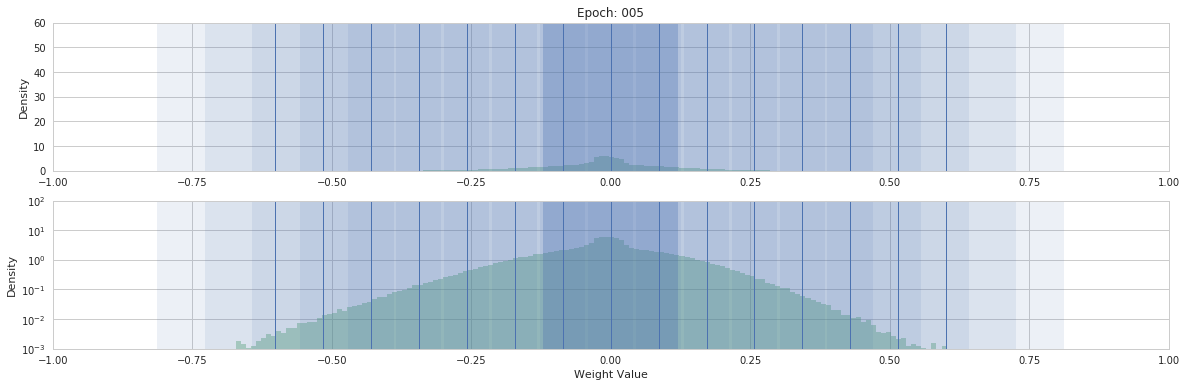

0.02458820305764675 4.835891246795654
0.026001479476690292 4.8315348625183105
0.025359496474266052 4.827205181121826
0.02616790682077408 4.8228654861450195
0.025057028979063034 4.818544387817383
0.027387283742427826 4.814214706420898
0.0270378477871418 4.809912204742432
0.02421095408499241 4.805611610412598
0.02648400142788887 4.801272392272949
0.02715092897415161 4.796960830688477
0.02872924879193306 4.792656898498535
0.02795490249991417 4.788387298583984
0.029083725064992905 4.784103870391846
0.028314320370554924 4.779835224151611
0.02910386025905609 4.775559902191162
0.027893036603927612 4.771292686462402
0.030230820178985596 4.767021179199219
0.030093353241682053 4.762782573699951
0.0281224325299263 4.758530139923096
0.029657401144504547 4.754262447357178
0.03126557171344757 4.750013828277588
0.028283843770623207 4.745787143707275
0.03132602944970131 4.741528034210205
0.031092945486307144 4.737302303314209
0.02919445000588894 4.733074188232422
0.03197770193219185 4.7288312911987305

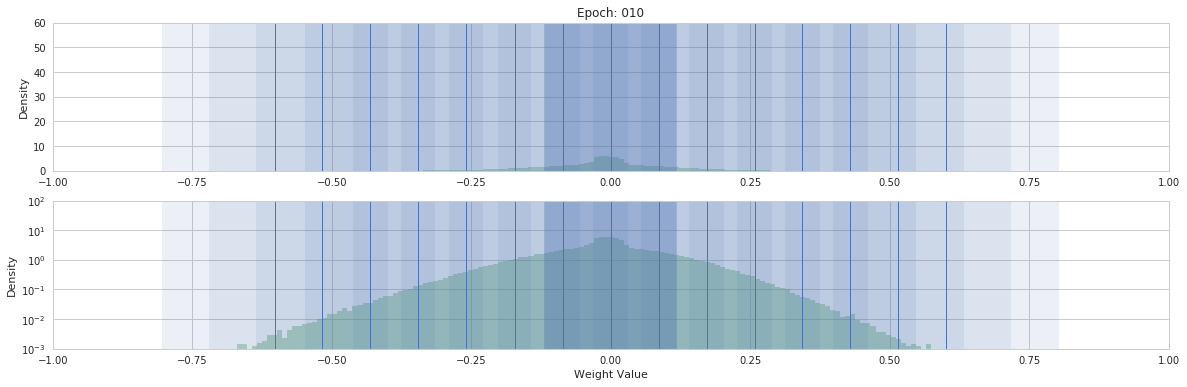

0.07672838121652603 4.025021076202393
0.07326657325029373 4.021152973175049
0.07360361516475677 4.017241477966309
0.08136800676584244 4.013326644897461
0.06828954070806503 4.0094709396362305
0.07410566508769989 4.00551700592041
0.07547618448734283 4.001615524291992
0.07344485819339752 3.9977054595947266
0.07181675732135773 3.9937851428985596
0.07482260465621948 3.9898624420166016
0.0805341973900795 3.9859554767608643
0.07143077999353409 3.982085943222046
0.08180323988199234 3.9781436920166016
0.08025215566158295 3.9742772579193115
0.07633247971534729 3.9704060554504395
0.07595468312501907 3.9664905071258545
0.07931361347436905 3.9625914096832275
0.080002561211586 3.958712339401245
0.08226391673088074 3.954815626144409
0.08131978660821915 3.950960159301758
0.08524121344089508 3.9470841884613037
0.07574330270290375 3.943228006362915
0.07844220846891403 3.93931245803833
0.08006661385297775 3.935399055480957
0.08204508572816849 3.931504487991333
0.07702503353357315 3.9276280403137207
0.073

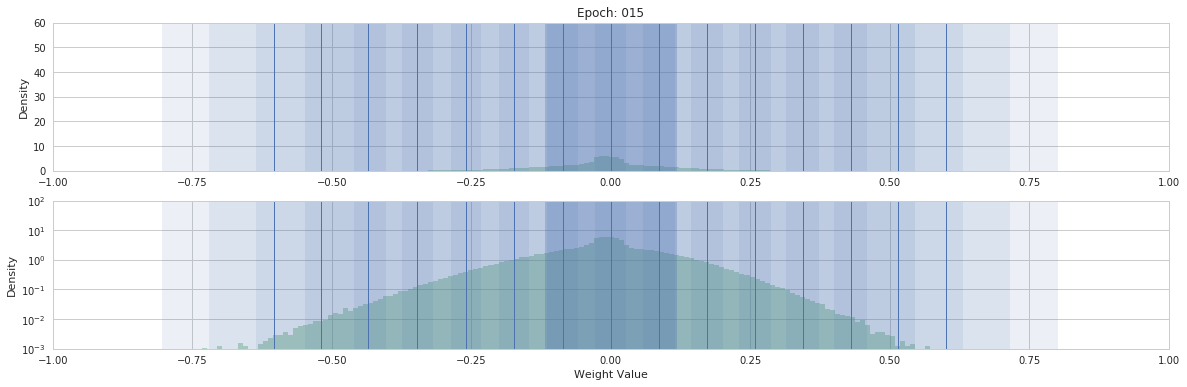

0.12644152343273163 3.2528834342956543
0.12749072909355164 3.2490429878234863
0.13188977539539337 3.2451858520507812
0.12865011394023895 3.241370916366577
0.13673825562000275 3.237520217895508
0.1386283040046692 3.2337217330932617
0.13267925381660461 3.2299468517303467
0.13990961015224457 3.226125717163086
0.12628133594989777 3.222329616546631
0.13699126243591309 3.21846866607666
0.13839519023895264 3.2146530151367188
0.13379605114459991 3.210853099822998
0.13759618997573853 3.2070326805114746
0.1311049908399582 3.203223466873169
0.13662835955619812 3.1993772983551025
0.13162393867969513 3.195560932159424
0.13291537761688232 3.1917312145233154
0.13044387102127075 3.1878952980041504
0.13655392825603485 3.184037446975708
0.13314874470233917 3.180222511291504
0.14836858212947845 3.176378011703491
0.13043545186519623 3.1725990772247314
0.1321617066860199 3.1687405109405518
0.13737176358699799 3.1648881435394287
0.1459244042634964 3.161064863204956
0.1388244777917862 3.1572859287261963
0.13

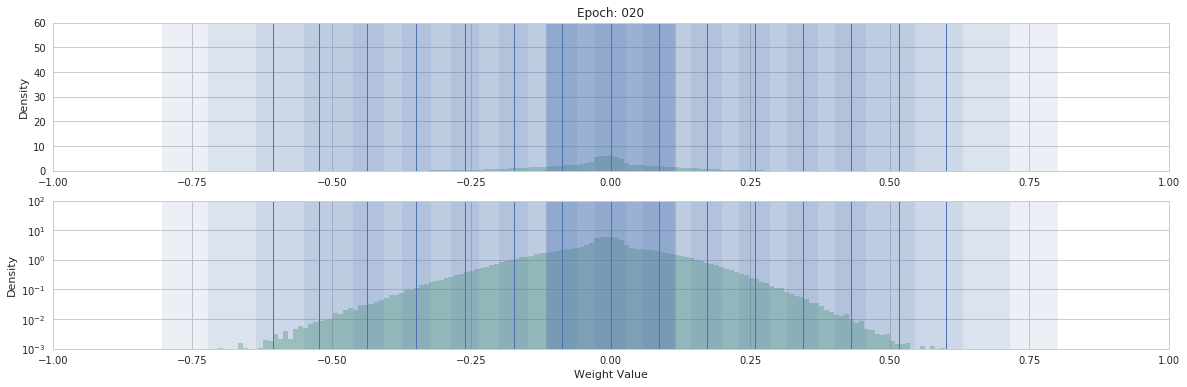

0.20640167593955994 2.4907734394073486
0.20224575698375702 2.4870219230651855
0.18781030178070068 2.4832451343536377
0.19911837577819824 2.4793920516967773
0.2001577466726303 2.475614070892334
0.1964569389820099 2.471843719482422
0.19968251883983612 2.468050003051758
0.19548192620277405 2.4642789363861084
0.19084368646144867 2.460495948791504
0.19688576459884644 2.456704616546631
0.2002483755350113 2.4529287815093994
0.19287201762199402 2.4491422176361084
0.21164464950561523 2.4453320503234863
0.1946108639240265 2.441596746444702
0.2034355103969574 2.43780779838562
0.18841131031513214 2.4340498447418213
0.1970738172531128 2.430208444595337
0.19854725897312164 2.426417827606201
0.1976408064365387 2.4226131439208984
0.20351776480674744 2.4188156127929688
0.196714386343956 2.4150476455688477
0.20253601670265198 2.4112327098846436
0.20057989656925201 2.40744686126709
0.19919735193252563 2.40366792678833
0.20797130465507507 2.3998546600341797
0.1959845870733261 2.396108627319336
0.203985095

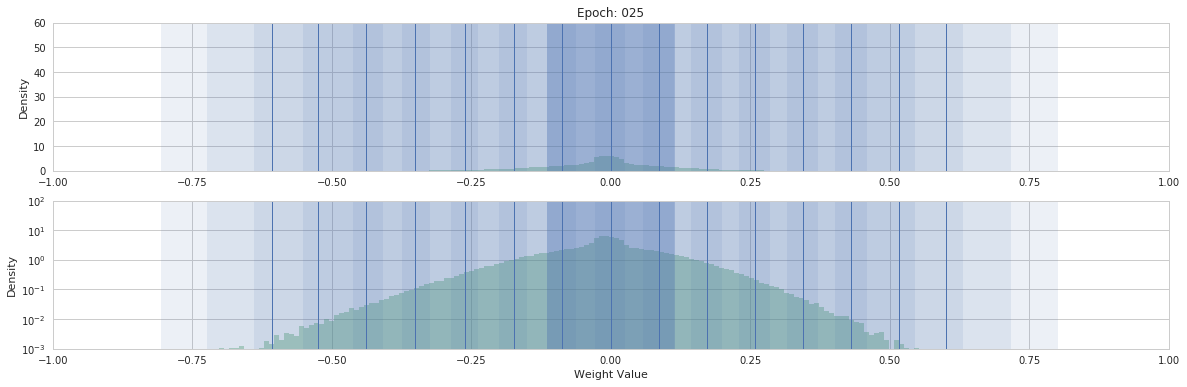

0.26826491951942444 1.7339078187942505
0.25861817598342896 1.7301445007324219
0.251939058303833 1.72634756565094
0.252689927816391 1.7225226163864136
0.25465869903564453 1.718721866607666
0.27129873633384705 1.7149358987808228
0.2602039873600006 1.7111703157424927
0.2688150107860565 1.707376480102539
0.26222729682922363 1.7036304473876953
0.26062440872192383 1.6998530626296997
0.26385360956192017 1.6960577964782715
0.2565472722053528 1.6922874450683594
0.26324304938316345 1.6884788274765015
0.2665082514286041 1.6846851110458374
0.2683272063732147 1.6809022426605225
0.2760162949562073 1.6771491765975952
0.27593672275543213 1.6733944416046143
0.275818794965744 1.6696178913116455
0.26895636320114136 1.6658670902252197
0.2750375270843506 1.6620742082595825
0.24968640506267548 1.658313274383545
0.2835410237312317 1.654464840888977
0.274082213640213 1.6507327556610107
0.26001206040382385 1.64697265625
0.2595018446445465 1.6431421041488647
0.28914228081703186 1.639297604560852
0.2617119252681

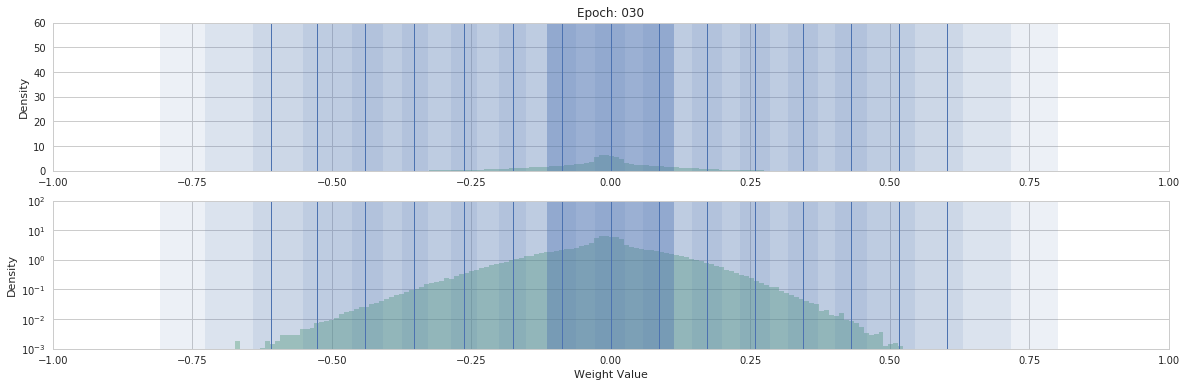

0.3550412952899933 0.9790288805961609
0.33686399459838867 0.9753015637397766
0.3341466188430786 0.9715492129325867
0.33688443899154663 0.9677491784095764
0.3188120126724243 0.963989794254303
0.35299551486968994 0.9601202607154846
0.3467077612876892 0.9563890099525452
0.32180559635162354 0.9526468515396118
0.34705471992492676 0.9488241672515869
0.3384513854980469 0.9450780749320984
0.31267058849334717 0.9413406252861023
0.3667321503162384 0.9374867081642151
0.3335873782634735 0.9337859153747559
0.31274715065956116 0.9300171732902527
0.3508673906326294 0.9261468648910522
0.3135697543621063 0.922446072101593
0.3382543921470642 0.9186233878135681
0.35593128204345703 0.9148468375205994
0.33986082673072815 0.9111343622207642
0.3418726921081543 0.9073538780212402
0.3330439329147339 0.9035648107528687
0.35105064511299133 0.8997578024864197
0.359070360660553 0.8960031270980835
0.35693860054016113 0.8922624588012695
0.34227487444877625 0.8885296583175659
0.3266087472438812 0.884765625
0.33799067

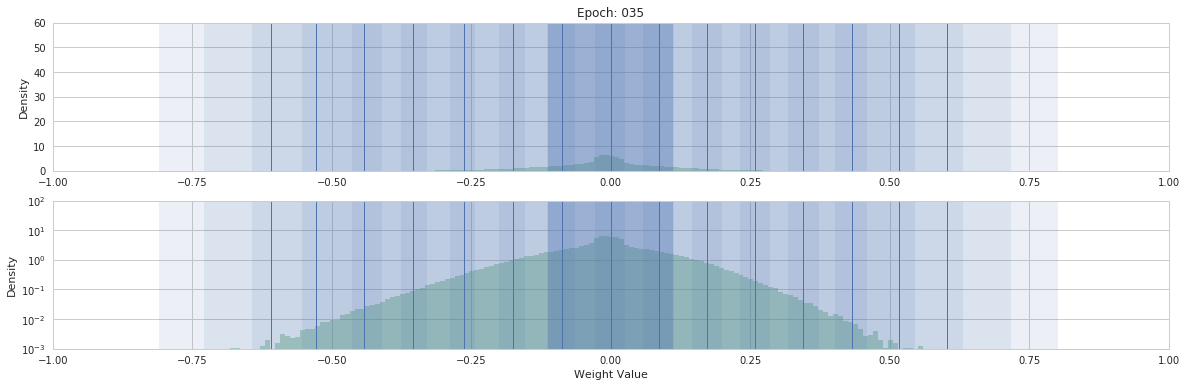

0.3890320360660553 0.22419999539852142
0.41540831327438354 0.22039061784744263
0.37416210770606995 0.2166031152009964
0.4340444505214691 0.21274374425411224
0.418372243642807 0.2090124934911728
0.406256765127182 0.20524843037128448
0.44449034333229065 0.20147499442100525
0.39662647247314453 0.19779139757156372
0.41107282042503357 0.19397187232971191
0.43308737874031067 0.19017420709133148
0.40832871198654175 0.1864296793937683
0.4225677251815796 0.18264062702655792
0.42419731616973877 0.17888905107975006
0.40529516339302063 0.17513437569141388
0.4125362038612366 0.17136874794960022
0.4112098217010498 0.1675804704427719
0.4114273190498352 0.1638101488351822
0.42026636004447937 0.1600250005722046
0.4415293037891388 0.15623359382152557
0.4514303505420685 0.1525132805109024
0.4153543710708618 0.1488359272480011
0.3907131552696228 0.14503905177116394
0.41767847537994385 0.14118202030658722
0.46323004364967346 0.13738124072551727
0.42767515778541565 0.13374295830726624
0.40669676661491394 0.

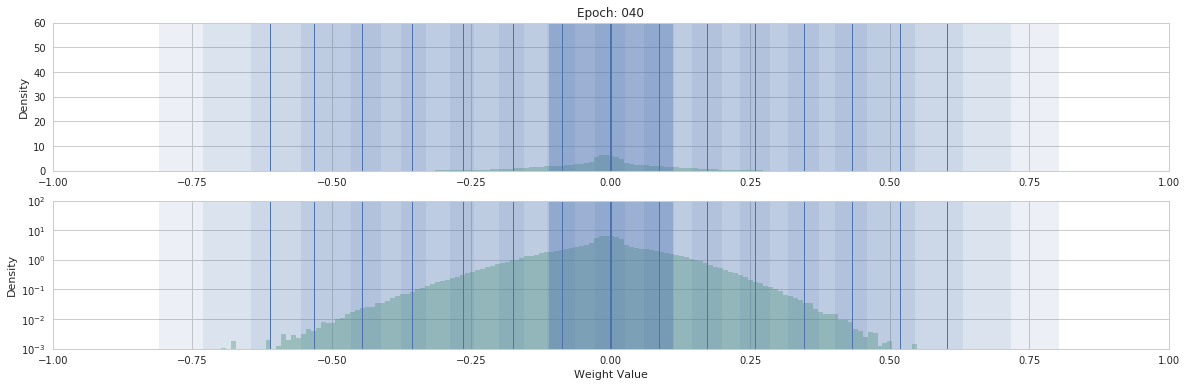

0.5046712160110474 -0.5329218506813049
0.48530012369155884 -0.5366835594177246
0.49691274762153625 -0.5404921770095825
0.4567449986934662 -0.5442984104156494
0.5492623448371887 -0.5482031106948853
0.49036890268325806 -0.5518375039100647
0.47454676032066345 -0.5556319952011108
0.48282870650291443 -0.5594617128372192
0.5055680274963379 -0.5632851123809814
0.4737229645252228 -0.5670202970504761
0.5007014274597168 -0.5708343386650085
0.49571606516838074 -0.5746530890464783
0.5197935700416565 -0.5784648060798645
0.5113779306411743 -0.5821687579154968
0.5238878726959229 -0.5859187245368958
0.4453589618206024 -0.5896515250205994
0.5171859860420227 -0.5935421586036682
0.5013366341590881 -0.5972812175750732
0.5474740266799927 -0.6010648012161255
0.5467082262039185 -0.6047124862670898
0.531597912311554 -0.608384370803833
0.4815279245376587 -0.6120781302452087
0.47041061520576477 -0.615904688835144
0.5256276726722717 -0.6197835803031921
0.5001099109649658 -0.6235038638114929
0.4854350686073303 -0

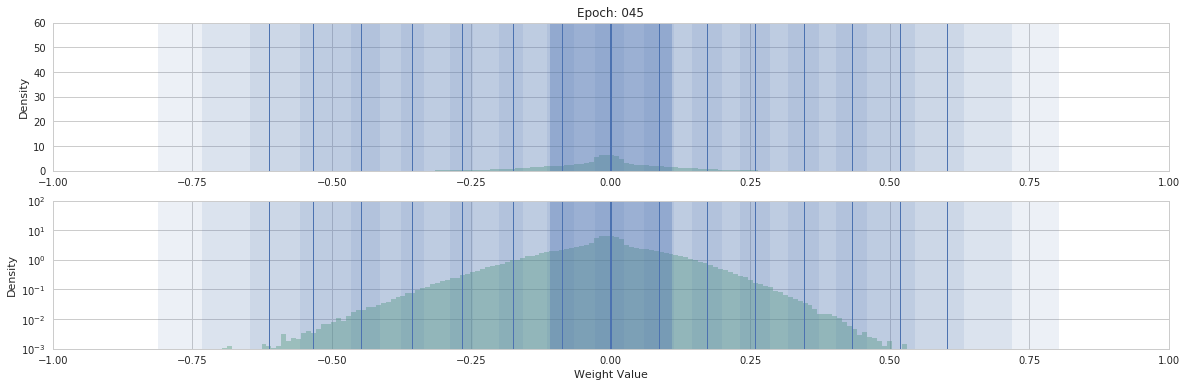

0.5554144382476807 -1.2917389869689941
0.586766242980957 -1.2955937385559082
0.5681633353233337 -1.2993882894515991
0.5668445825576782 -1.3031820058822632
0.5552626848220825 -1.3070405721664429
0.5470576286315918 -1.310838222503662
0.5616155862808228 -1.3147194385528564
0.5886324644088745 -1.3185718059539795
0.5983268618583679 -1.3223687410354614
0.5418247580528259 -1.3260999917984009
0.540935218334198 -1.329966425895691
0.5882683396339417 -1.3338639736175537
0.5947402119636536 -1.3376554250717163
0.6236761808395386 -1.341417908668518
0.5524935126304626 -1.3451429605484009
0.5771757960319519 -1.3490039110183716
0.6023573279380798 -1.3528132438659668
0.548658013343811 -1.356571078300476
0.5832592248916626 -1.3604742288589478
0.5700375437736511 -1.3642593622207642
0.5824342966079712 -1.3681139945983887
0.6151555776596069 -1.3718678951263428
0.5851995944976807 -1.3756006956100464
0.5791272521018982 -1.379420280456543
0.6342079639434814 -1.3832381963729858
0.5458321571350098 -1.38695383071

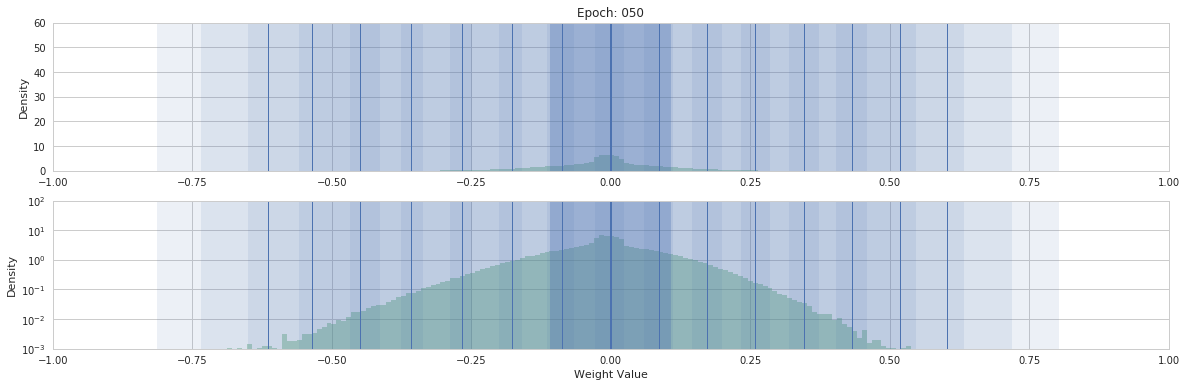

In [5]:
model_name = "SWSModel"
training_epochs = 100
model_file = 'mnist_{}_{}'.format(model_name, training_epochs)
model_orig = torch.load("{}{}.m".format(model_dir, model_file)).cuda()
layer_model = models.SWSModelFC1().cuda()
input = (nn.ReLU()(torch.load("{}{}/{}.out.m".format(model_dir, model_file, "conv2")))).data
output = torch.load("{}{}/{}.out.m".format(model_dir, model_file, "fc1")).data
if T != 0:
    output = (nn.Softmax(dim=1)(Variable(output/T))).data

dataset = torch.utils.data.TensorDataset(input[55000:], output[55000:])
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

layer_model, gmp = retrain_layer(layer_model, model_orig, loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, model_dir + model_file)